(234, 7)
输出test_x
2
[[[0.43809523809523654, 0.4571428571428555, 0.5333333333333314, 0.5999999999999996, 0.5999999999999996, 0.685714285714285], [0.4571428571428555, 0.5333333333333314, 0.5999999999999996, 0.5999999999999996, 0.685714285714285, 0.6666666666666661], [0.5333333333333314, 0.5999999999999996, 0.5999999999999996, 0.685714285714285, 0.6666666666666661, 0.5809523809523789], [0.5999999999999996, 0.5999999999999996, 0.685714285714285, 0.6666666666666661, 0.5809523809523789, 0.485714285714284], [0.5999999999999996, 0.685714285714285, 0.6666666666666661, 0.5809523809523789, 0.485714285714284, 0.40000000000000036], [0.685714285714285, 0.6666666666666661, 0.5809523809523789, 0.485714285714284, 0.40000000000000036, 0.40952380952380807]], [[0.6666666666666661, 0.5809523809523789, 0.485714285714284, 0.40000000000000036, 0.40952380952380807, 0.42857142857142705], [0.5809523809523789, 0.485714285714284, 0.40000000000000036, 0.40952380952380807, 0.42857142857142705, 0.40000000000000036], 

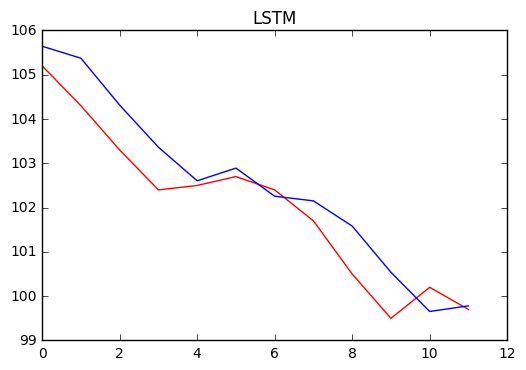

In [3]:
# 加载数据分析常用库
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import pandas as pd#导入数据的包
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
log_dir = 'F:\\CPILSTM' 
#加载数据
f=open('F:\\CPILSTM\\CPIQG01.csv') 
df=pd.read_csv(f)#读入数据从csv文件中导入数据
data=df.iloc[:,0:7].values#取1到6列
print(data.shape)#返回数据3374*6

#定义常量
rnn_unit=10       #hidden layer units
input_size=6      
output_size=1
lr=0.0005         #学习率
tf.reset_default_graph()
#输入层、输出层权重、偏置
with tf.name_scope('w'):
    weights={
             'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
             'out':tf.Variable(tf.random_normal([rnn_unit,1]))#5*10,10*1 
             }
with tf.name_scope('b'):
    biases={
            'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
            'out':tf.Variable(tf.constant(0.1,shape=[1,]))#10
            }

#分割数据集，将数据分为训练集和验证集，后90天作为测试集
with tf.name_scope('getdata'):
    def get_data(batch_size=12,time_step=6,train_begin=0,train_end=222):
            batch_index=[]    
            scaler_for_x=MinMaxScaler(feature_range=(0,1))  #按列做minmax缩放，数据归一化结构方式
            scaler_for_y=MinMaxScaler(feature_range=(0,1))
            scaled_x_data=scaler_for_x.fit_transform(data[:,:-1])#3374*6
            scaled_y_data=scaler_for_y.fit_transform(data[:,-1].reshape(-1,1))
            scaled_y_data = scaled_y_data.flatten()
        #     data_train=data[train_begin:train_end]
            label_train = scaled_y_data[train_begin:train_end]#0-3283S实际值
            label_test = scaled_y_data[train_end:]#3283-end
            normalized_train_data = scaled_x_data[train_begin:train_end]#0-3283
            normalized_test_data = scaled_x_data[train_end:]#3283-end

            train_x,train_y=[],[]   #训练集x和y初定义
            for i in range(len(normalized_train_data)-time_step):
                if i % batch_size==0:
                    batch_index.append(i)#将能整出60的数追加在batch_index中
                x=normalized_train_data[i:i+time_step,:6]
                y=label_train[i:i+time_step,np.newaxis]
                train_x.append(x.tolist())#将数组或者矩阵变为列表#训练输入
                train_y.append(y.tolist())#训练输出
        # print('输出train_y')
        # print(train_y)
            batch_index.append((len(normalized_train_data)-time_step))

            size=(len(normalized_test_data)+time_step-1)//time_step  #有size个sample 
            test_x,test_y=[],[]  
            for i in range(size-1):
                x=normalized_test_data[i*time_step:(i+1)*time_step,:6]
                y=label_test[i*time_step:(i+1)*time_step]
                test_x.append(x.tolist())
                test_y.extend(y)
            test_x.append((normalized_test_data[(i+1)*time_step:,:6]).tolist())#测试输入
            test_y.extend((label_test[(i+1)*time_step:]).tolist())#测试输出
            print('输出test_x')
            print(len(test_x))
            print(test_x)
            print('输出train_x')
            print(len(train_x))
        #     print(train_x)
            return batch_index,train_x,train_y,test_x,test_y,scaler_for_y

#——————————————————定义神经网络变量——————————————————
with tf.name_scope('lstm'):
    def lstm(X):  
        batch_size=tf.shape(X)[0]
        time_step=tf.shape(X)[1]
        w_in=weights['in']
        b_in=biases['in']
        input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入

        input_rnn=tf.matmul(input,w_in)+b_in

        input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
        cell=tf.contrib.rnn.BasicLSTMCell(rnn_unit)
        #cell=tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(rnn_unit)
        init_state=cell.zero_state(batch_size,dtype=tf.float32)
        output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
        output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
        w_out=weights['out']
        b_out=biases['out']
        pred=tf.matmul(output,w_out)+b_out
    #     pred=tf.nn.softmax(tf.matmul(output,w_out)+b_out)
        return pred,final_states

#——————————————————训练模型——————————————————

    #损失函数
#     loss=tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(Y, [-1]),logits=tf.reshape(pred,[-1]))
    #loss=tf.reduce_mean(l)
    
    #with tf.name_scope('loss'):
with tf.name_scope('train-lstm'):
    def train_lstm(batch_size=12,time_step=6,train_begin=0,train_end=222):
    #     with tf.name_scope('input'):
            X=tf.placeholder(tf.float32, shape=[None,time_step,input_size],name='x-input')
            Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size],name='y-input')
            batch_index,train_x,train_y,test_x,test_y,scaler_for_y = get_data(batch_size,time_step,train_begin,train_end)
            pred,_=lstm(X)
            with tf.name_scope('loss'):
                loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])),name='loss')
                tf.summary.scalar('loss',loss)
            with tf.name_scope('train'):
                train_op=tf.train.AdamOptimizer(lr).minimize(loss)
            merged=tf.summary.merge_all()
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())#初始化模型变量参数
                writer=tf.summary.FileWriter('F:\\数据文件\\graph',sess.graph)
            #重复训练5000次
                iter_time = 1000
                for i in range(iter_time):
                    for step in range(len(batch_index)-1):
                        _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
                    if i % 200 == 0:    
                        print('iter:',i,'loss:',loss_)
                ####预测模型####
                with tf.name_scope('predict'):
                        test_predict=[]
                        for step in range(len(test_x)):
                            prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
                            predict=prob.reshape((-1))
                            test_predict.extend(predict)
                        test_predict=np.array(test_predict)
                        test_y=np.array(test_y)
                        test_predict = scaler_for_y.inverse_transform(test_predict.reshape(1,-1))#用上面的结构反归一化
                        test_y = scaler_for_y.inverse_transform(test_y.reshape(1,-1))#用上面的结构反归一化
                        print('输出len(test_x)')
                        print(len(test_x))
                        print('test_predict值')
                        print(test_predict.shape)
                        print(test_predict)
                        test_y=np.array(test_y)
                        print('test_y值')
                        print(test_y.shape)
                        print(test_y)
                         #判断指标
                        rmse=np.sqrt(mean_squared_error(test_predict,test_y))
                        mae = mean_absolute_error(y_pred=test_predict,y_true=test_y)
                        test_predict = np.concatenate(test_predict, axis=0)
                        error = abs(test_predict-test_y)
                        ec=1-np.sqrt(sum(error*error))/(np.sqrt(sum(test_y*test_y))+np.sqrt(sum(test_predict*test_predict)));
                        ec=np.mean(ec)
                        print ('mae:',mae,'   rmse:',rmse,'    ec:',ec)
                        test_y=test_y.reshape(-1,1)
        #         test_predict=test_predict(-1,1)
                        plt.figure()
                        plt.plot(test_y,  color='r')
                        plt.plot(test_predict, color='b')
                        plt.title('LSTM')
                        plt.show()
                return test_predict

    test_predict = train_lstm(batch_size=12,time_step=6,train_begin=0,train_end=222)